In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from importlib import reload

import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
from trecs.models import ContentFiltering

import src.globals as globals
import seaborn as sns

from wrapper.models.bubble import BubbleBurster
from src.utils import *
from src.plotting import plot_measurements 
from src.scoring_functions import cosine_sim, entropy, content_fairness, cosine_sim2
from wrapper.metrics.evaluation_metrics import *

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

/var/folders/sm/hcy50x855gvf2b1qwkjstnvh0000gn/T/ipykernel_42281/1763468719.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
n_attrs=20
max_iter=1000
n_clusters=10

In [3]:
binary_ratings_matrix = load_and_process_movielens(file_path='/Users/madisonthantu/Desktop/DREAM/data/ml-100k/u.data')

In [4]:
# Get user and item representations using NMF
user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)

Loaded embeddings.


In [5]:
# Define topic clusters using NMF
item_cluster_ids, item_cluster_centers = get_clusters(item_representation.T, name='item', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)
user_cluster_ids, user_cluster_centers = get_clusters(user_representation, name='user', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)

Loaded clusters.
Loaded clusters.


In [6]:
num_users = len(user_representation)
num_items = len(item_representation)
print(f'Number of items: {num_items}')
print(f'Number of users: {num_users}')

users = Users(actual_user_profiles=user_representation, 
              repeat_interactions=False, 
            #   drift=drift,
            #   attention_exp=attention_exp)
)

Number of items: 20
Number of users: 943


In [7]:
# Create user pairs for global `InteractionSimilarity` metric
global_user_pairs = []
num_users = len(user_cluster_ids)

for u_idx in range(num_users):
    global_user_pairs += [(u_idx, v_idx) for v_idx in range(u_idx+1, num_users)]

In [8]:
print(len(global_user_pairs))
print(global_user_pairs[:10])
print(global_user_pairs[-10:])

444153
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10)]
[(938, 939), (938, 940), (938, 941), (938, 942), (939, 940), (939, 941), (939, 942), (940, 941), (940, 942), (941, 942)]


In [9]:
# Create user_pairs by pairing users only with others that are not in the same cluster
user_item_cluster_mapping = user_topic_mapping(user_representation, item_cluster_centers) # TODO: Remove?
# Create user_pairs by pairing users only with others that are not in the same cluster
inter_cluster_user_pairs, intra_cluster_user_pairs = create_cluster_user_pairs(user_item_cluster_mapping)

In [10]:
mse = MSEMeasurement()
measurements = [
    MSEMeasurement(),  
    InteractionSpread(),                
    InteractionSimilarity(pairs=global_user_pairs, name='global_interaction_similarity'), 
    InteractionSimilarity(pairs=inter_cluster_user_pairs, name='inter_cluster_interaction_similarity'), 
    InteractionSimilarity(pairs=intra_cluster_user_pairs, name='intra_cluster_interaction_similarity'), 
    # RecSimilarity(pairs=inter_cluster_user_pairs, name='inter_cluster_rec_similarity'), 
    # RecSimilarity(pairs=intra_cluster_user_pairs, name='intra_cluster_rec_similarity'), 
    # DiversityMetric(), 
    # MeanNumberOfTopics(),
    # IntraClusterCosineSim(mapping=user_item_cluster_mapping, n_clusters=n_clusters, name='intra_user_to_topic_cluster_cos_sim'),
    # IntraClusterCosineSim(mapping=user_cluster_ids, n_clusters=n_clusters, name='intra_user_cluster_cos_sim'),
    # MeanDistanceFromCentroid(user_cluster_ids, user_cluster_centers, name='user_cluster_avg_distance_from_centroid'),
]

In [11]:
BB = BubbleBurster(
    actual_user_representation=users, 
    actual_item_representation=item_representation,
    item_topics=item_cluster_ids,
    num_attributes=n_attrs,
    num_items_per_iter=10,
    seed=42,
    record_base_state=True
)

BB.add_metrics(*measurements)

In [12]:
# Fair Model
train_timesteps = 10
BB.startup_and_train(timesteps=train_timesteps)

run_timesteps = 50
BB.run(timesteps=run_timesteps, train_between_steps=False)

100%|██████████| 50/50 [04:58<00:00,  5.97s/it]


In [13]:
BB_measurements = BB.get_measurements()
# for k in measurements.keys():
#     print(k, len(measurements[k]))
BB_measurements_df = pd.DataFrame(BB_measurements)

BB_measurements_df.head()

# centroid_dist = measurements_df["user_cluster_avg_distance_from_centroid"]

,mse,interaction_spread,global_interaction_similarity,inter_cluster_interaction_similarity,intra_cluster_interaction_similarity,timesteps
0,0.090065,NaN,NaN,NaN,NaN,0
1,0.090065,-939.0,0.001668,0.001092,0.001715,1
2,0.090065,0.0,0.002206,0.001760,0.002241,2
3,0.090065,0.5,0.002960,0.002515,0.002995,3
4,0.090065,-1.0,0.003723,0.003310,0.003756,4


In [14]:
for k in BB_measurements.keys():
    print(k, len(BB_measurements[k]))

mse 61
interaction_spread 61
global_interaction_similarity 61
inter_cluster_interaction_similarity 61
intra_cluster_interaction_similarity 61
timesteps 61


In [15]:
print(BB_measurements['interaction_spread'])

[None, -939.0, 0.0, 0.5, -1.0, 0.5, 0.5, -0.5, 1.0, -0.5, -1.5, 21.5, -4.5, -8.5, -1.5, -0.5, -2.5, 1.5, -1.5, 1.0, 4.0, 2.0, -4.5, -0.5, 1.0, -1.0, -1.5, 5.0, -3.0, -1.5, 1.0, 3.0, -3.0, 1.0, 0.0, 2.0, -3.0, 0.5, -2.0, 1.0, 0.5, -1.5, 1.5, -0.5, 4.0, -2.5, -1.0, -2.0, 0.0, 3.0, -1.0, -1.0, 4.0, -3.5, 0.5, 3.5, -4.0, 0.0, 5.0, -5.5, 4.0]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


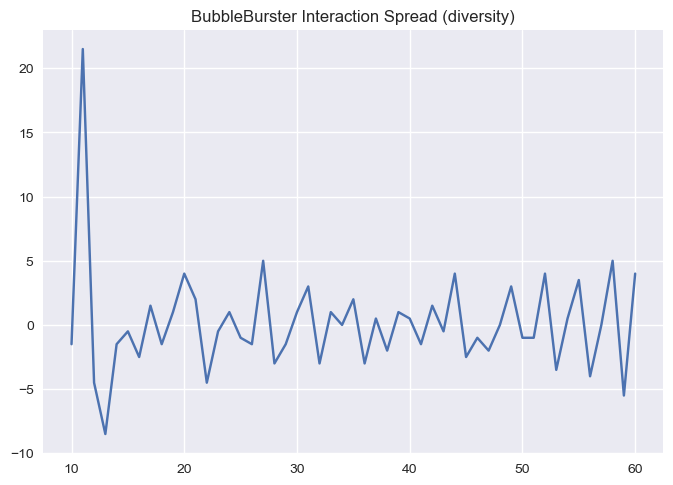

In [16]:
timesteps = BB_measurements['timesteps']

plt.plot(timesteps[train_timesteps:], BB_measurements['interaction_spread'][train_timesteps:])

plt.title("BubbleBurster Interaction Spread (diversity)")
plt.legend()
plt.show()

Text(0.5, 1.0, 'BubbleBurster Inter-Cluster Interaction Similarity')

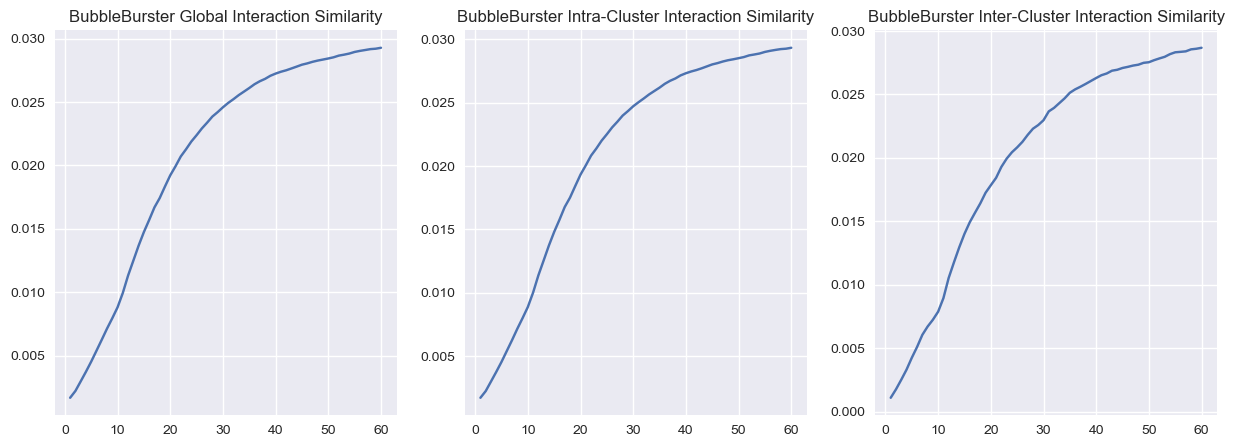

In [17]:
timesteps = BB_measurements['timesteps']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(timesteps, BB_measurements['global_interaction_similarity'])
ax1.set_title('BubbleBurster Global Interaction Similarity')
ax2.plot(timesteps, BB_measurements['intra_cluster_interaction_similarity'])
ax2.set_title('BubbleBurster Intra-Cluster Interaction Similarity')
ax3.plot(timesteps, BB_measurements['inter_cluster_interaction_similarity'])
ax3.set_title('BubbleBurster Inter-Cluster Interaction Similarity')

100%|██████████| 50/50 [10:57<00:00, 13.15s/it]

mse 122
interaction_spread 122
global_interaction_similarity 122
inter_cluster_interaction_similarity 122
intra_cluster_interaction_similarity 122
timesteps 122


Text(0.5, 1.0, 'BubbleBurster Inter-Cluster Interaction Similarity')

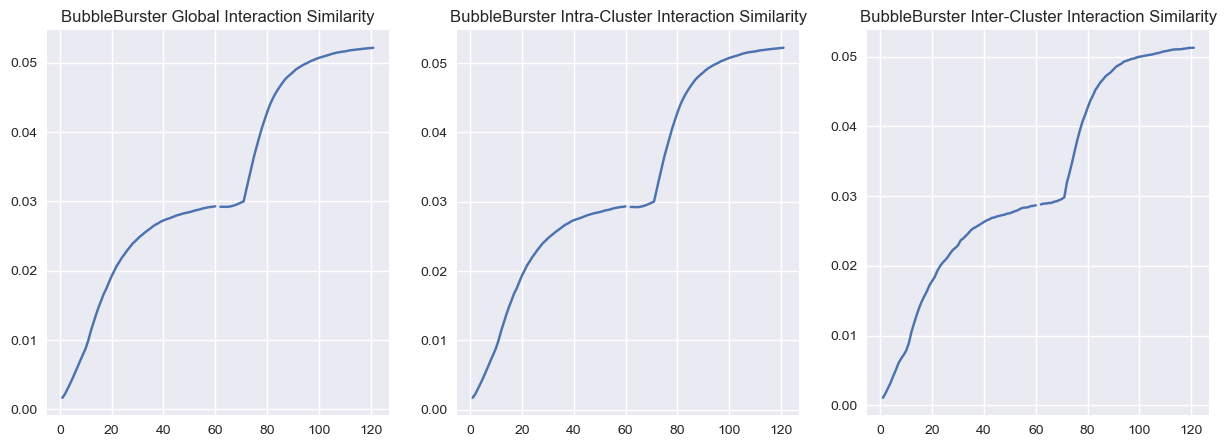

In [18]:
BB_retrain = BubbleBurster(
    actual_user_representation=users, 
    actual_item_representation=item_representation,
    item_topics=item_cluster_ids,
    num_attributes=n_attrs,
    num_items_per_iter=10,
    seed=42,
    record_base_state=True
)

BB_retrain.add_metrics(*measurements)

train_timesteps = 10
BB_retrain.startup_and_train(timesteps=train_timesteps)

run_timesteps = 50
BB_retrain.run(timesteps=run_timesteps, train_between_steps=True)

BB_retrain_measurements = BB.get_measurements()

for k in BB_retrain_measurements.keys():
    print(k, len(BB_retrain_measurements[k]))
    
timesteps = BB_retrain_measurements['timesteps']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(timesteps, BB_retrain_measurements['global_interaction_similarity'])
ax1.set_title('BubbleBurster Global Interaction Similarity')
ax2.plot(timesteps, BB_retrain_measurements['intra_cluster_interaction_similarity'])
ax2.set_title('BubbleBurster Intra-Cluster Interaction Similarity')
ax3.plot(timesteps, BB_retrain_measurements['inter_cluster_interaction_similarity'])
ax3.set_title('BubbleBurster Inter-Cluster Interaction Similarity')

In [12]:
# CF = ContentFiltering(
#     actual_user_representation=users, 
#     actual_item_representation=item_representation,
#     # item_topics=item_cluster_ids,
#     num_attributes=n_attrs,
#     num_items_per_iter=10,
#     seed=42,
#     record_base_state=True
# )

# CF.add_metrics(*measurements)

In [13]:
# train_timesteps=10
# CF.startup_and_train(timesteps=train_timesteps)

# CF_measurements = CF.get_measurements()
# # for k in measurements.keys():
# #     print(k, len(measurements[k]))
# CF_measurements_df = pd.DataFrame(CF_measurements)

# CF_measurements_df.head()

# # centroid_dist = measurements_df["user_cluster_avg_distance_from_centroid"]

100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


,mse,interaction_spread,inter_cluster_interaction_similarity,intra_cluster_interaction_similarity,timesteps
0,0.090065,NaN,NaN,NaN,0
1,0.090065,-939.0,0.001092,0.001715,1
2,0.090065,0.0,0.001760,0.002241,2
3,0.090065,0.5,0.002515,0.002995,3
4,0.090065,-1.0,0.003310,0.003756,4


In [ ]:
# centroid_dist = np.stack(centroid_dist.to_numpy())
# centroid_dist.shape

In [ ]:
# timesteps = measurements['timesteps']
# for clust_idx in range(centroid_dist.shape[1]):
#     plt.plot(timesteps, centroid_dist[:, clust_idx], label="cluster_"+str(clust_idx+1))

# plt.title("Average Distance from Centroid by Cluster Over Time")
# plt.legend()
# plt.show()

In [ ]:
# plt.plot(timesteps, centroid_dist.mean(axis=1))

# plt.title("Average Distance from Centroid Across Clusters Over Time")
# plt.legend()
# plt.show()

In [ ]:
# clusters = np.unique(user_cluster_ids)
# avg_clust_dist = np.zeros((user_cluster_centers.shape[0], 1))
# for clust in clusters:
#     clust_users = np.where(user_cluster_ids == clust)[0]
#     clust_users_embed = model.users.actual_user_profiles.value[clust_users,:]
#     dist = np.linalg.norm(user_cluster_centers[clust] - clust_users_embed, axis=1)
#     avg_clust_dist[clust] = np.mean(dist)
# # self.observe(avg_clust_dist)